# Importing file dependencies for the code.

In [241]:
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import astropy_mpl_style
from glob import glob
import os
import numpy as np
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import LombScargle
from astropy.io import fits
from scipy import optimize
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore", module='astropy.wcs.wcs')
from astropy.timeseries import LombScargle


# Setting defaults for the plots.

In [3]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['errorbar.capsize'] = 3
opts = {'mec':'k', 'mew': 0.5, 'lw': 1}

# Importing the fits files.

In [175]:
#importing the data from the base directory, and adding the names to a variable with glob
datadir = '/home/taterz/V453Cyg_data/'
fnames = glob(os.path.join(datadir, '*.fits'))

data_month1 = fits.getdata(fnames[0], ext=1)
data_month2 = fits.getdata(fnames[1], ext=1)

# get quality flag of 0 for each set of data
flag_check1 = data_month1['QUALITY'] == 0
lc_data_month1 = data_month1[flag_check1]

flag_check2 = data_month2['QUALITY'] == 0
lc_data_month2 = data_month2[flag_check2]

## Defining some functions to be used later. They work like subroutines.

In [195]:
def remove_eclipse(flux, eclp_flux): 
    """Removes the eclipsing dips from the flux. Uses fits file flux data and a number 
        for the estimated eclipse flux count. 
    
    'flux' - filtered fits data array containing flux values
    'eclp_flux' - value for the eclipse flux
    
    'flux_eclp_rm - further filtered fits data array holding removed eclipse data'
    """

    #applies a truth check to filter out values above the value given from input
    flag_check_flux = flux['SAP_FLUX'] >= eclp_flux
    flux_eclp_rm = flux[flag_check_flux]
    
    
    return flux_eclp_rm

Using this new function to remove the eclipse from the first month's data.

Text(0, 0.5, 'Unnormalized Flux Count')

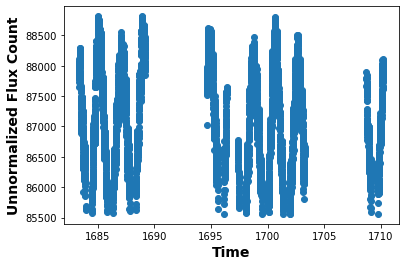

In [378]:
month1_eclp_rm = remove_eclipse(lc_data_month1, 85560)
plt.scatter(month1_eclp_rm['TIME'], month1_eclp_rm['SAP_FLUX'])
plt.xlabel("Time")
plt.ylabel("Unnormalized Flux Count")

In [73]:
def lomb_scargle(times, flux):
    """Takes the time list and flux to determine the most probable frequency.
        Returns value for the frequencies, power ratings, and max period.
    
    'times' - list holding the time measurements
    'flux' - list holding the flux measurements
    """
    freq, power = LombScargle(times, flux).autopower()
    max_period = 1 / freq[np.argmax(power)]
    
    return freq, power, max_period

Using the above function to determine the estimated period of the major curve.

In [208]:
freq_month1, pow_month1, max_period_month1 = lomb_scargle(month1_eclp_rm['TIME'], month1_eclp_rm['SAP_FLUX'])

In [432]:
def losc_plot(freq, power, period):
    """Simple function to plot the values for the lomb scargle output.
    
    'freq' - list holding the frequencies 
    'power' - list holding the relative power values
    'period' - value for the maximum power frequency corresponding to the period
    
    """
    
    plt.plot(freq, power, 'r', lw=5)
    plt.ylabel('Power')
    plt.xlabel('Frequency (1/day)')
    print("The max period is:", '%.5f'%period, "days.")

The max period is: 1.93167 days.


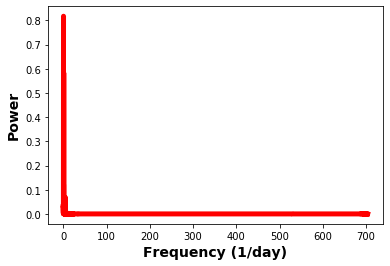

In [433]:
losc_plot(freq_month1, pow_month1, max_period_month1)

In [214]:
def phase_fold_plot(times, flux, period):
    """Creates a plot of the phase folded flux based on the max period.
    
    'times' - array holding the time values
    'flux' - array holding the flux values
    'period' - value for the max period
    
    """
    #period = 3.89
    plt.plot(times % period, flux, 'r+');
    plt.xlabel('Phase (days)')
    plt.ylabel('Magnitude')
    plt.grid();

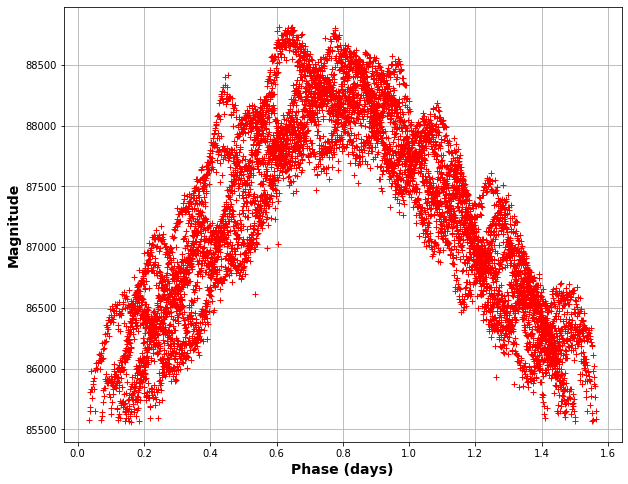

In [215]:
phase_fold_plot(month1_eclp_rm['TIME'], month1_eclp_rm['SAP_FLUX'], max_period_month1)

Using the code from stackexchange to create a least fit function to fit a sine curve to the phase folded data.

In [426]:
def sine_func(x, a, b, c):
    return a * np.sin(b*x + c)

def curve_fitter(times, fluxes, period, func, amp):
    """Uses scipy's curve fit function to find a best fitted function based on
        user's input function.
        
    'times' - array holding the time values
    'fluxes' - array holding the flux values
    'period' - estimated period of the trend
    'func' - function to be fitted
    'amp' - initial estimate of the amplitude
    
    'params' - parameters for the fitted function
    'pcovar' - covariance of the parameters
    """
    fold_times = times % period
    params, pcovar = curve_fit(func, fold_times, fluxes, p0=[amp, period, 0])
    
    return params

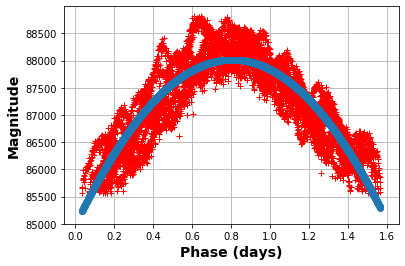

In [428]:
#making a new variable to hold the times, fold times and fluxes for the first month
#should have been done earlier, but the fits array was needed to remove the eclipse
fold_times_m1 = month1_eclp_rm['TIME'] % max_period_month1
times_m1 = month1_eclp_rm['TIME']
fluxes_m1 = month1_eclp_rm['SAP_FLUX']

phase_fold_plot(times_m1, fluxes_m1, max_period_month1)

params_m1 = curve_fitter(fold_times_m1, fluxes_m1, max_period_month1, sine_func, 1200)

#the fitted function, zorder of value 10 prioritizes its layering on top
plt.scatter(fold_times, params_m1[0]*np.sin(params_m1[1]*fold_times_m1 + params_m1[2]),zorder=10)

In [326]:
def detrend(fold_times, fluxes, params, func):
    """Detrends the data based on the fitted function.
        
    'fold_times' - array holding the folded time values
    'fluxes' - array holding the flux values
    'func' - function to be fitted    
    'params' - parameters for the fitted function

    """
    #using the fitted model function to detrend the data
    y_fit = func(fold_times, params[0], params[1], params[2])
    flux_detrended = fluxes - y_fit
    
    return flux_detrended

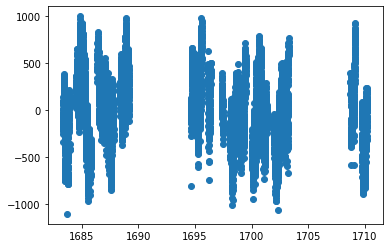

In [429]:
flux_m1_dtrd = detrend(fold_times_m1, fluxes_m1, params_m1, sine_func)
plt.scatter(times_m1, flux_m1_dtrd)

The max period is: 0.20234 days.


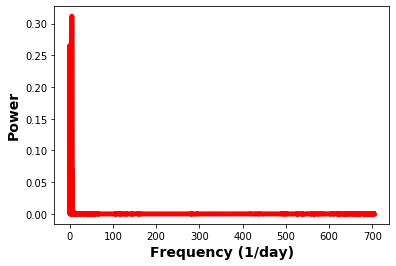

In [434]:
#using the detrended data to find and remove the smaller humps
losc_dtrd = lomb_scargle(times_m1, fluxes_m1_dtrd)
losc_plot(losc_dtrd[0],losc_dtrd[1],losc_dtrd[2])

### With the major hump gone, it should be a simple matter of repeating the earlier steps to determine and remove the secondary hump.

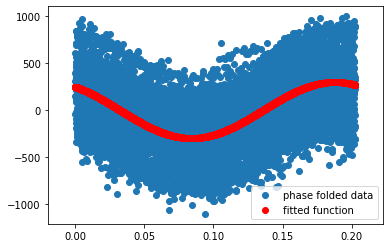

In [501]:
#since this is the second hump, times will be signified by h2
fold_times_m1_h2 = times_m1%losc_dtrd[2]
params_m1_h2 = curve_fitter(times_m1, fluxes_m1_dtrd, losc_dtrd[2], sine_func, 100)
plt.scatter(fold_times_m1_h2, flux_m1_dtrd, label='phase folded data')

#likewise, the secondary fitted function will be signified by 2
y2_fit = sine_func(fold_times_m1_h2, params_m1_h2[0], params_m1_h2[1], params_m1_h2[2])
plt.scatter(fold_times_m1_h2, y2_fit, color='red', label='fitted function')
plt.legend()

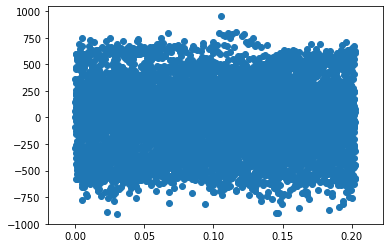

In [342]:
#running through the detrend function in order to remove the small humps
fluxes_m1_dtrd_h2 = detrend(fold_times_m1_h2, fluxes_m1_dtrd, params_m1_h2, sine_func)
plt.scatter(fold_times_m1_h2, fluxes_m1_dtrd_h2)

The max period is: 0.00001 days.


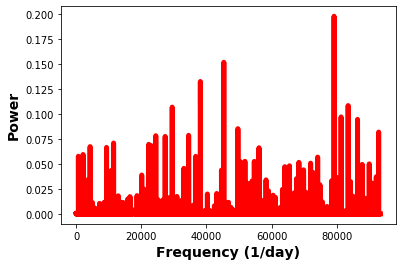

In [435]:
losc_dtrd_h3 = lomb_scargle(fold_times_m1_h2, fluxes_m1_dtrd_h2)
losc_plot(losc_dtrd_h3[0], losc_dtrd_h3[1], losc_dtrd_h3[2])

### Data looks relatively well detrended, so now I try to remove the function from the original data to hopefully detrend the smaller humps.

(1683, 1688)

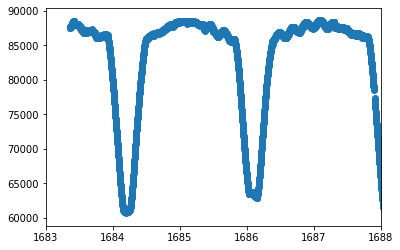

In [538]:
times_m1_full = lc_data_month1['TIME']
times_m1_full_fold = times_m1_full % (max_period_month1 + 0.01)
fluxes_m1_full = lc_data_month1['SAP_FLUX']

#params_fitted = [200, params_m1_h2[1], params_m1_h2[2]]
final_data_m1 = detrend(times_m1_full_fold, fluxes_m1_full, params_m1_h2, sine_func)

#plt.scatter(times_m1_full_fold, final_data_m1)
plt.scatter(times_m1_full, final_data_m1)
plt.xlim(1683,1688)

In [540]:
import csv
with open('detrended_data.csv', mode='w') as detrended_data:
    detrended_writer = csv.writer(detrended_data, delimiter=' ')
    for i in range(len(final_data_m1)):
        detrended_writer.writerow([times_m1_full[i], final_data_m1[i]])